# Question 1 work in CIFAR-10 Dataset

## Checking Avilable GPU

In [ ]:
!nvidia-smi

Sat Jan 28 13:21:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    20W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing requirements

In [ ]:
# pytorch libs
import torch
from torch import nn
import torchvision

# matplot libs
import matplotlib.pyplot as plt

# numpy
import numpy as np

# torch metrics
try:
  import torchmetrics
except:
  !pip3 -q install torchmetrics
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 8.0 MB/s eta 0:00:00


## device agnostic code

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Getting Dataset with pytorch

### Downloading Dataset

In [ ]:
from torchvision import transforms

image_trasform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ]
)

train_dataset = torchvision.datasets.CIFAR10(
    root = 'data/',
    download = True,
    train = True,
    transform = image_trasform
)

test_dataset = torchvision.datasets.CIFAR10(
    root = 'data/',
    download = True,
    train = False,
    transform = image_trasform
)
train_dataset,test_dataset

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: data/
     Split: Train
     StandardTransform
 Transform: Compose(
                Grayscale(num_output_channels=1)
                ToTensor()
            ), Dataset CIFAR10
     Number of datapoints: 10000
     Root location: data/
     Split: Test
     StandardTransform
 Transform: Compose(
                Grayscale(num_output_channels=1)
                ToTensor()
            ))

### Vis. dataset (train dataset)

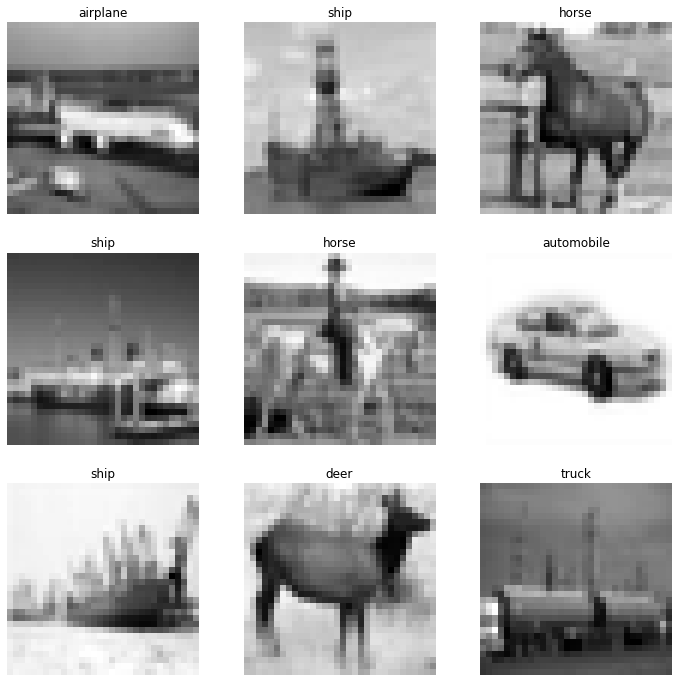

In [ ]:
# randomly ploting image samples from the grayscale dataset
labels_map = test_dataset.class_to_idx # getting class -> index map
labels_map = dict(map(reversed, labels_map.items())) # inverting dict
# print(labels_map)

figure = plt.figure(figsize=(12, 12)) # fixing plotsize
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)) # randomely selecting one image sample from the image index
    img, label = train_dataset[sample_idx] # getting image and label of selected index
    # sub plot code
    figure.add_subplot(rows, cols, i) 
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(),cmap="gray") # NOTE:- Color map is gray because we're converting imgae to grayscale
    # sub plot code ends
plt.show()

### Converting dataset to dataloader

In [ ]:
import os

# hyper parms. for dataloader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count() # no. of avilable cpu cores

# train dataloader
train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers =  NUM_WORKERS   
)

# test dataloader
test_dataloader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers =  NUM_WORKERS   
)

print(f"Numbers of Batches in Train Dataloader: {len(train_dataloader)}")
print(f"Numbers of Batches in Test Dataloader: {len(test_dataloader)}")
# train_dataloader,test_dataloader

Numbers of Batches in Train Dataloader: 1563
Numbers of Batches in Test Dataloader: 313


## Defining model

In [ ]:
class CIFAR10Model0(nn.Module):
  def __init__(
      self,
      in_channels:int,
      hidden_units:int,
      out_channels:int,
      num_layers:int,
      activation_funtion:nn.Module
      ) -> None:
    '''
    args:
      in_channels: input image shape
      hidden_units: number of hidden in neural net.
      out_channels: number of classes in the data
      num_layers: number of layers including i/p and o/p layers
      actication_function: activation function of your choice
    '''
    super().__init__()
    self.num_layers = num_layers # no of layers in the neural net.
    layer_list = [nn.Flatten()]
    for i in range(num_layers):
      # print(f"creating layer: {i}, out of: {num_layers}")
      if i == 0: # input layer def.
        layer_list.append(nn.Linear(in_features=in_channels,out_features=hidden_units))
        layer_list.append(activation_funtion)
      elif i == num_layers - 1: # out layer def.
        layer_list.append(nn.Linear(in_features=hidden_units,out_features=out_channels))
      else:
        layer_list.append(nn.Linear(in_features=hidden_units,out_features=hidden_units))
        layer_list.append(activation_funtion)
    
    # print("layer list:")
    # print(*layer_list,sep = '\n')
    self.block = nn.Sequential(*layer_list)

  def forward(self,x:torch.Tensor):
    return self.block(x)


## Training model

### making model object

In [ ]:
height = next(iter(train_dataloader))[0].shape[2]
width = next(iter(train_dataloader))[0].shape[2]
height,width

(32, 32)

In [ ]:
class_names = train_dataloader.dataset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
model_sigmode_3_layers = CIFAR10Model0(
    in_channels = height*width,
    hidden_units = 16,
    out_channels = len(class_names),
    num_layers = 3,
    activation_funtion = nn.Sigmoid()
    ).to(device)
print("\nMODEL INFO: \n")
print(model_sigmode_3_layers)


MODEL INFO: 

CIFAR10Model0(
  (block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=16, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [ ]:
model_tanh_3_layers = CIFAR10Model0(
    in_channels = height*width,
    hidden_units = 16,
    out_channels = len(class_names),
    num_layers = 3,
    activation_funtion = nn.Tanh()
    ).to(device)
print("\nMODEL INFO: \n")
print(model_sigmode_3_layers)


MODEL INFO: 

CIFAR10Model0(
  (block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=16, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=16, out_features=10, bias=True)
  )
)


### making training testing steps and train model functions

#### train step

In [ ]:
def training_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    device: str
    ):
    """
    Desc:
      funtion to perform traning step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      optimizer (torch.optim.Optimizer): Optimizer Function (object) of your choice
      device (str): Torch Device "CPU/GPU"
    Returns:
      train_loss (float), train_acc (float): training loss and training accuracy for one EPOCH
    """
    model.train() # putting model in traing model

    train_loss, train_acc = 0, 0 # initlizing loss and acc. for the epoch

    # print(type(model.parameters()))
    for (X,y) in dataloader: # loop in batches
      # model_parms_before_forward_pass = np.array([x.detach().numpy() for x in model.parameters()].copy())
      X,y = X.to(device), y.to(device) # sending the data to target device
      # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

      # 1. forward pass
      y_pred_logits = model(X)

      # 2. calculate the loss
      loss = loss_fn(y_pred_logits, y)
      train_loss += loss.item()

      # 3. optimizer zero grad
      optimizer.zero_grad()

      # 4. loss backword
      loss.backward()

      # 5. optimizer step
      optimizer.step()
      

      # model_parms_after_forward_pass = np.array([x.detach().numpy() for x in model.parameters()])
      # print("Model parms diff:")
      # print([(i,j) for (i,j) in zip(iter(model_parms_after_forward_pass),iter(model_parms_before_forward_pass))])
      # print(model_parms_after_forward_pass - model_parms_before_forward_pass,sep="\n")
      train_acc += acc_fn(y_pred_logits.argmax(dim = 1), y).item()

    # 6. returning actual loss and acc.x
    return train_loss/len(dataloader), train_acc/len(dataloader)



#### test step

In [ ]:
def testing_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    device: str
    ):
    """
    Desc:
      funtion to perform testing step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): testing dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
    Returns:
      test_loss (float), test_acc (float): testing loss and testing accuracy for one EPOCH
    """
    model.eval() # putting model in eval model

    test_loss, test_acc = 0, 0 # initlizing loss and acc. for the epoch

    with torch.inference_mode():
      for (X,y) in dataloader: # loop in batches
        X,y = X.to(device), y.to(device) # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

        # 1. forward pass
        y_pred_logits = model(X)

        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        test_loss += loss.item()

        # 3. calculating accuracy
        test_acc += acc_fn(y_pred_logits.argmax(dim = 1), y).item()

    # 6. returning actual loss and acc.
    return test_loss/len(dataloader), test_acc/len(dataloader)

#### training function

In [ ]:
from tqdm.auto import tqdm

def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    epochs: int,
  ):
  """
    Desc:
      funtion to perform training for one {epochs} param

    Args:
      model (nn.Module): Pytorch model class object
      train_dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      test_dataloader (torch.utils.data.DataLoader): testing dataloder from testing dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
    Returns:
      result_dict ({str: List[float]}): testing loss and testing accuracy for one EPOCH
  """
  # 1. init. result dict
  result_dict = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
    }
  
  # 2. loop in range epochs performs train and test steps on the model
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = training_step(
                                            model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            acc_fn=acc_fn,
                                            optimizer=optimizer,
                                            device=device
                                          )

    test_loss, test_acc = testing_step(
                                        model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        acc_fn=acc_fn,
                                        device=device
                                      )
  
  # 3. print out results
    print(
              f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}"
          )
    
  # 4. adding results to result_dict
    result_dict["train_loss"].append(train_loss)
    result_dict["train_acc"].append(train_acc)
    result_dict["test_loss"].append(test_loss)
    result_dict["test_acc"].append(test_acc)

  # 5. return result dict
  return result_dict

### train loop for model_sigmode_3_layers

In [ ]:
# init. epochs
NUM_EPOCHS = 20

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)
optimizer = torch.optim.Adam(params=model_sigmode_3_layers.parameters(), lr=0.001)

# importing and init. the timer for checking model training time
from timeit import default_timer as timer
start_time = timer()

# train model
model_sigmoid_3_layer_results = train(model=model_sigmode_3_layers, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        acc_fn=acc_fn,
                        epochs=NUM_EPOCHS)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
# print("model stats:")
# print(model_0_results)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0116 | train_acc: 0.2531 | test_loss: 2.0009 | test_acc: 0.2554
Epoch: 2 | train_loss: 1.9881 | train_acc: 0.2652 | test_loss: 1.9667 | test_acc: 0.2711
Epoch: 3 | train_loss: 1.9602 | train_acc: 0.2799 | test_loss: 1.9397 | test_acc: 0.2862
Epoch: 4 | train_loss: 1.9360 | train_acc: 0.2890 | test_loss: 1.9303 | test_acc: 0.2825
Epoch: 5 | train_loss: 1.9157 | train_acc: 0.2953 | test_loss: 1.9060 | test_acc: 0.2979
Epoch: 6 | train_loss: 1.8971 | train_acc: 0.3005 | test_loss: 1.8793 | test_acc: 0.3055
Epoch: 7 | train_loss: 1.8830 | train_acc: 0.3048 | test_loss: 1.8839 | test_acc: 0.3038
Epoch: 8 | train_loss: 1.8698 | train_acc: 0.3099 | test_loss: 1.8531 | test_acc: 0.3187
Epoch: 9 | train_loss: 1.8568 | train_acc: 0.3157 | test_loss: 1.8452 | test_acc: 0.3182
Epoch: 10 | train_loss: 1.8475 | train_acc: 0.3213 | test_loss: 1.8426 | test_acc: 0.3231
Epoch: 11 | train_loss: 1.8396 | train_acc: 0.3229 | test_loss: 1.8292 | test_acc: 0.3250
Epoch: 12 | train_l

### train loop for model_tanh_3_layers

In [ ]:
# init. epochs
NUM_EPOCHS = 20

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)
optimizer = torch.optim.Adam(params=model_tanh_3_layers.parameters(), lr=0.001)

# importing and init. the timer for checking model training time
from timeit import default_timer as timer
start_time = timer()

# train model
model_tanh_3_layer_results = train(model=model_tanh_3_layers, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        acc_fn=acc_fn,
                        epochs=NUM_EPOCHS)


# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
# print("model stats:")
# print(model_0_results)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9583 | train_acc: 0.2820 | test_loss: 1.9830 | test_acc: 0.2763
Epoch: 2 | train_loss: 1.9321 | train_acc: 0.2925 | test_loss: 1.9256 | test_acc: 0.2922
Epoch: 3 | train_loss: 1.9085 | train_acc: 0.3032 | test_loss: 1.8909 | test_acc: 0.3070
Epoch: 4 | train_loss: 1.8925 | train_acc: 0.3095 | test_loss: 1.8676 | test_acc: 0.3175
Epoch: 5 | train_loss: 1.8797 | train_acc: 0.3139 | test_loss: 1.8564 | test_acc: 0.3240
Epoch: 6 | train_loss: 1.8702 | train_acc: 0.3213 | test_loss: 1.8622 | test_acc: 0.3166
Epoch: 7 | train_loss: 1.8617 | train_acc: 0.3231 | test_loss: 1.8608 | test_acc: 0.3187
Epoch: 8 | train_loss: 1.8540 | train_acc: 0.3241 | test_loss: 1.8476 | test_acc: 0.3274
Epoch: 9 | train_loss: 1.8477 | train_acc: 0.3258 | test_loss: 1.8217 | test_acc: 0.3368
Epoch: 10 | train_loss: 1.8419 | train_acc: 0.3304 | test_loss: 1.8399 | test_acc: 0.3271
Epoch: 11 | train_loss: 1.8378 | train_acc: 0.3310 | test_loss: 1.8095 | test_acc: 0.3393
Epoch: 12 | train_l

### plot loss and accuracy graphs

In [ ]:
from typing import Dict,List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

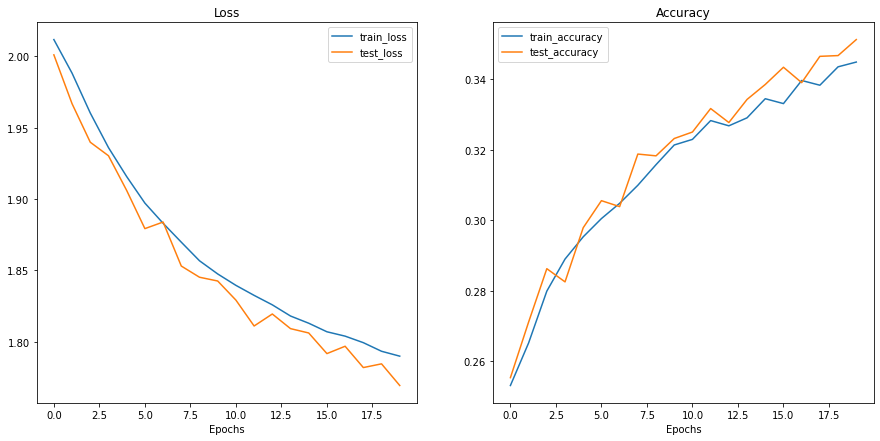

In [ ]:
plot_loss_curves(model_sigmoid_3_layer_results)
plot_loss_curves(model_tanh_3_layer_results)

## Exploring Vanishing Gradiant problem

### Increasing layers of model to hit vanishing gradiant with sigmoid activation

[INFO] traning model_sigmode_10_layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3066 | train_acc: 0.0960 | test_loss: 2.3052 | test_acc: 0.0965
Epoch: 2 | train_loss: 2.3058 | train_acc: 0.0956 | test_loss: 2.3035 | test_acc: 0.0969
Epoch: 3 | train_loss: 2.3053 | train_acc: 0.0968 | test_loss: 2.3042 | test_acc: 0.0971
Epoch: 4 | train_loss: 2.3053 | train_acc: 0.0962 | test_loss: 2.3054 | test_acc: 0.0960
Epoch: 5 | train_loss: 2.3049 | train_acc: 0.0958 | test_loss: 2.3064 | test_acc: 0.0964
Epoch: 6 | train_loss: 2.3047 | train_acc: 0.0969 | test_loss: 2.3039 | test_acc: 0.0964
Epoch: 7 | train_loss: 2.3047 | train_acc: 0.0969 | test_loss: 2.3049 | test_acc: 0.0970
Epoch: 8 | train_loss: 2.3044 | train_acc: 0.0972 | test_loss: 2.3042 | test_acc: 0.0966
Epoch: 9 | train_loss: 2.3044 | train_acc: 0.0964 | test_loss: 2.3035 | test_acc: 0.0969
Epoch: 10 | train_loss: 2.3042 | train_acc: 0.0967 | test_loss: 2.3044 | test_acc: 0.0962
total training time: 235.832 sec.


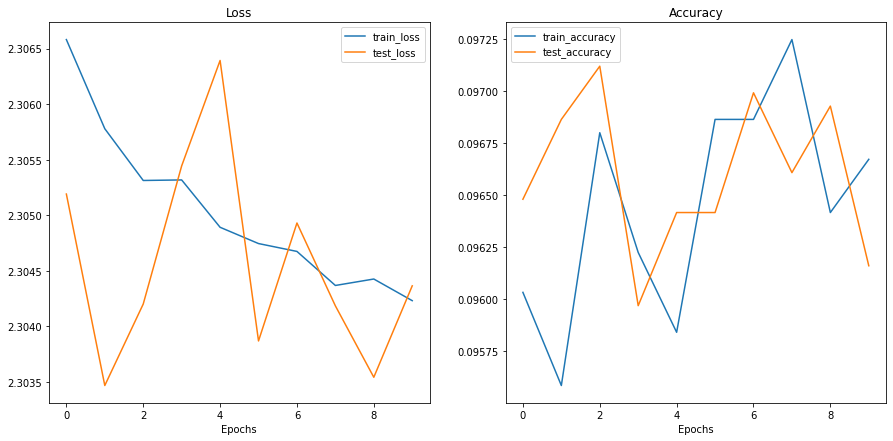

[INFO] traning model_sigmode_12_layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3067 | train_acc: 0.0966 | test_loss: 2.3051 | test_acc: 0.0958
Epoch: 2 | train_loss: 2.3057 | train_acc: 0.0965 | test_loss: 2.3139 | test_acc: 0.0963
Epoch: 3 | train_loss: 2.3059 | train_acc: 0.0959 | test_loss: 2.3049 | test_acc: 0.0965
Epoch: 4 | train_loss: 2.3055 | train_acc: 0.0967 | test_loss: 2.3040 | test_acc: 0.0966
Epoch: 5 | train_loss: 2.3052 | train_acc: 0.0962 | test_loss: 2.3047 | test_acc: 0.0967
Epoch: 6 | train_loss: 2.3049 | train_acc: 0.0966 | test_loss: 2.3050 | test_acc: 0.0971
Epoch: 7 | train_loss: 2.3048 | train_acc: 0.0959 | test_loss: 2.3030 | test_acc: 0.0966
Epoch: 8 | train_loss: 2.3046 | train_acc: 0.0972 | test_loss: 2.3045 | test_acc: 0.0971
Epoch: 9 | train_loss: 2.3046 | train_acc: 0.0964 | test_loss: 2.3041 | test_acc: 0.0962
Epoch: 10 | train_loss: 2.3043 | train_acc: 0.0958 | test_loss: 2.3035 | test_acc: 0.0969
total training time: 229.798 sec.


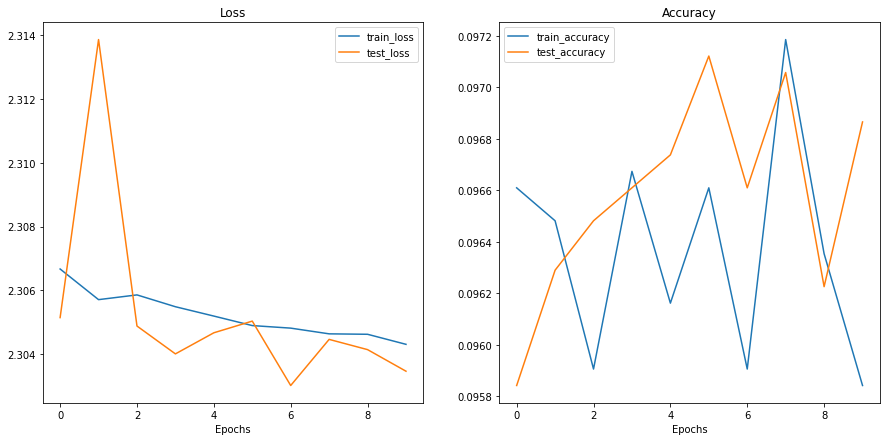

[INFO] traning model_sigmode_14_layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3062 | train_acc: 0.0968 | test_loss: 2.3046 | test_acc: 0.0971
Epoch: 2 | train_loss: 2.3054 | train_acc: 0.0965 | test_loss: 2.3038 | test_acc: 0.0956
Epoch: 3 | train_loss: 2.3054 | train_acc: 0.0966 | test_loss: 2.3040 | test_acc: 0.0962
Epoch: 4 | train_loss: 2.3052 | train_acc: 0.0969 | test_loss: 2.3039 | test_acc: 0.0975
Epoch: 5 | train_loss: 2.3050 | train_acc: 0.0969 | test_loss: 2.3038 | test_acc: 0.0958
Epoch: 6 | train_loss: 2.3047 | train_acc: 0.0960 | test_loss: 2.3036 | test_acc: 0.0968
Epoch: 7 | train_loss: 2.3044 | train_acc: 0.0965 | test_loss: 2.3038 | test_acc: 0.0966
Epoch: 8 | train_loss: 2.3045 | train_acc: 0.0970 | test_loss: 2.3033 | test_acc: 0.0963
Epoch: 9 | train_loss: 2.3043 | train_acc: 0.0964 | test_loss: 2.3040 | test_acc: 0.0967
Epoch: 10 | train_loss: 2.3042 | train_acc: 0.0964 | test_loss: 2.3050 | test_acc: 0.0958
total training time: 233.919 sec.


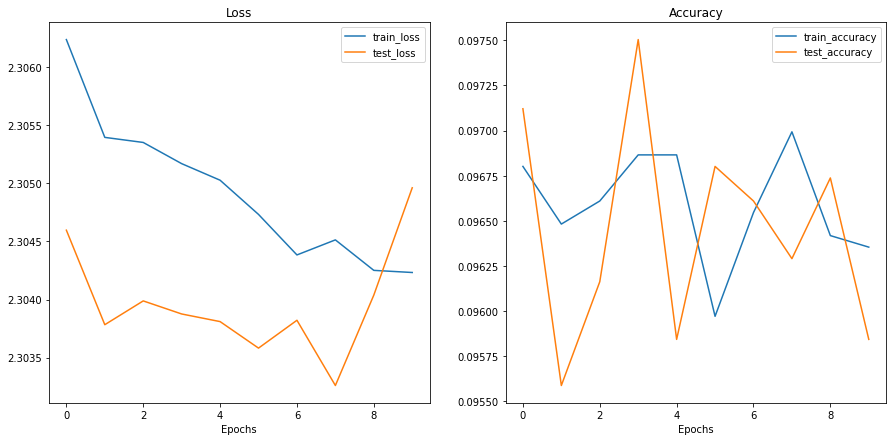

[INFO] traning model_sigmode_16_layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3069 | train_acc: 0.0970 | test_loss: 2.3082 | test_acc: 0.0969
Epoch: 2 | train_loss: 2.3058 | train_acc: 0.0965 | test_loss: 2.3044 | test_acc: 0.0964
Epoch: 3 | train_loss: 2.3057 | train_acc: 0.0959 | test_loss: 2.3054 | test_acc: 0.0974
Epoch: 4 | train_loss: 2.3053 | train_acc: 0.0965 | test_loss: 2.3052 | test_acc: 0.0972
Epoch: 5 | train_loss: 2.3050 | train_acc: 0.0968 | test_loss: 2.3033 | test_acc: 0.0962
Epoch: 6 | train_loss: 2.3050 | train_acc: 0.0967 | test_loss: 2.3044 | test_acc: 0.0974
Epoch: 7 | train_loss: 2.3046 | train_acc: 0.0964 | test_loss: 2.3048 | test_acc: 0.0953
Epoch: 8 | train_loss: 2.3047 | train_acc: 0.0961 | test_loss: 2.3036 | test_acc: 0.0960
Epoch: 9 | train_loss: 2.3044 | train_acc: 0.0961 | test_loss: 2.3029 | test_acc: 0.0967
Epoch: 10 | train_loss: 2.3043 | train_acc: 0.0964 | test_loss: 2.3037 | test_acc: 0.0962
total training time: 238.390 sec.


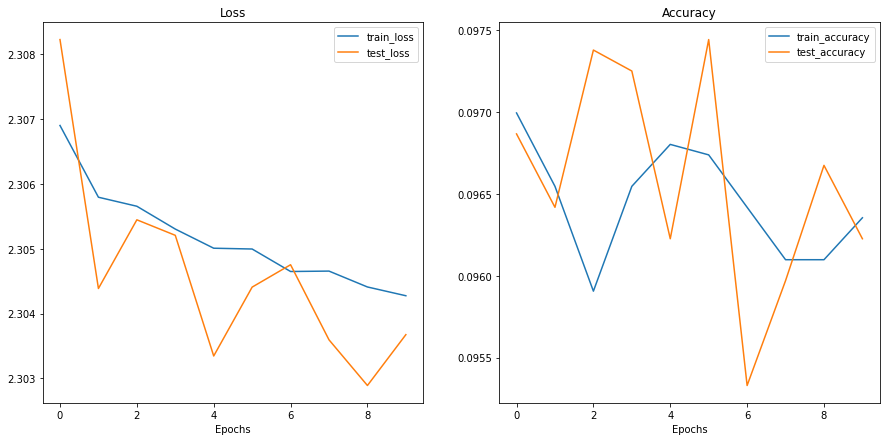

[INFO] traning model_sigmode_18_layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3064 | train_acc: 0.0958 | test_loss: 2.3047 | test_acc: 0.0976
Epoch: 2 | train_loss: 2.3057 | train_acc: 0.0965 | test_loss: 2.3057 | test_acc: 0.0959
Epoch: 3 | train_loss: 2.3054 | train_acc: 0.0967 | test_loss: 2.3045 | test_acc: 0.0965
Epoch: 4 | train_loss: 2.3048 | train_acc: 0.0971 | test_loss: 2.3036 | test_acc: 0.0962
Epoch: 5 | train_loss: 2.3050 | train_acc: 0.0968 | test_loss: 2.3035 | test_acc: 0.0959
Epoch: 6 | train_loss: 2.3046 | train_acc: 0.0966 | test_loss: 2.3051 | test_acc: 0.0960
Epoch: 7 | train_loss: 2.3043 | train_acc: 0.0963 | test_loss: 2.3041 | test_acc: 0.0971
Epoch: 8 | train_loss: 2.3044 | train_acc: 0.0967 | test_loss: 2.3040 | test_acc: 0.0959
Epoch: 9 | train_loss: 2.3043 | train_acc: 0.0974 | test_loss: 2.3046 | test_acc: 0.0969
Epoch: 10 | train_loss: 2.3041 | train_acc: 0.0967 | test_loss: 2.3039 | test_acc: 0.0956
total training time: 243.344 sec.


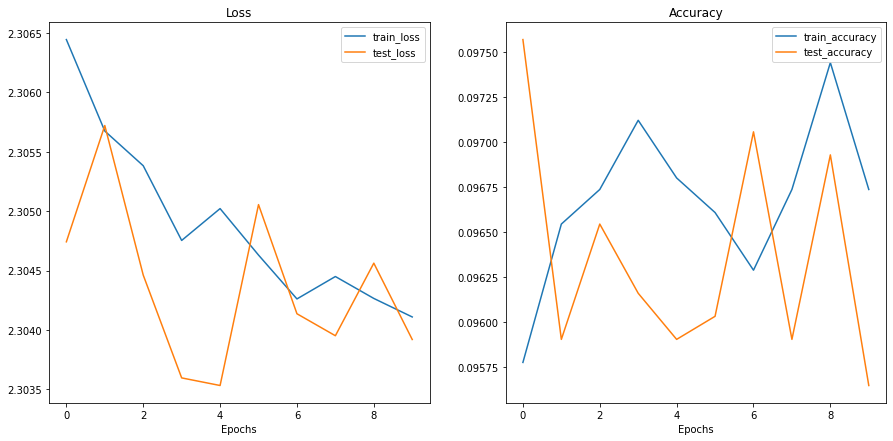

[INFO] traning model_sigmode_20_layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3065 | train_acc: 0.0963 | test_loss: 2.3059 | test_acc: 0.0965
Epoch: 2 | train_loss: 2.3056 | train_acc: 0.0969 | test_loss: 2.3060 | test_acc: 0.0965
Epoch: 3 | train_loss: 2.3055 | train_acc: 0.0965 | test_loss: 2.3061 | test_acc: 0.0969
Epoch: 4 | train_loss: 2.3052 | train_acc: 0.0971 | test_loss: 2.3054 | test_acc: 0.0955
Epoch: 5 | train_loss: 2.3052 | train_acc: 0.0963 | test_loss: 2.3063 | test_acc: 0.0969
Epoch: 6 | train_loss: 2.3050 | train_acc: 0.0972 | test_loss: 2.3043 | test_acc: 0.0965
Epoch: 7 | train_loss: 2.3046 | train_acc: 0.0968 | test_loss: 2.3040 | test_acc: 0.0960
Epoch: 8 | train_loss: 2.3045 | train_acc: 0.0971 | test_loss: 2.3044 | test_acc: 0.0962
Epoch: 9 | train_loss: 2.3046 | train_acc: 0.0961 | test_loss: 2.3037 | test_acc: 0.0966
Epoch: 10 | train_loss: 2.3043 | train_acc: 0.0970 | test_loss: 2.3046 | test_acc: 0.0971
total training time: 251.416 sec.


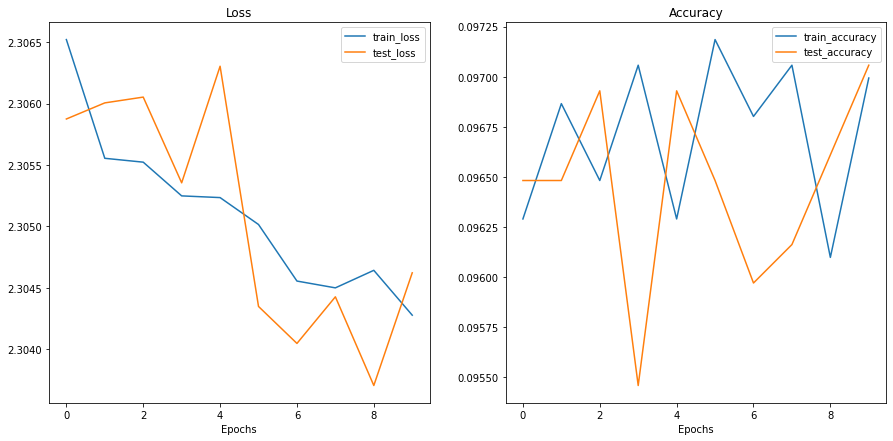

In [ ]:
for layer_counts in range(10,21,2):
  # making model object with sigmoid and layer count
  model_sigmode_x_layers = CIFAR10Model0(
    in_channels = height*width,
    hidden_units = 16,
    out_channels = len(class_names),
    num_layers = layer_counts,
    activation_funtion = nn.Sigmoid()
    ).to(device)
  # print("\nMODEL INFO: \n")
  # print(model_sigmode_x_layers)
  
  
  print(f"[INFO] traning model_sigmode_{layer_counts}_layers")
  # training the model
  # init. epochs
  NUM_EPOCHS = 10

  # init. loss function, accuracy function and optimizer
  loss_fn = nn.CrossEntropyLoss()
  acc_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)
  optimizer = torch.optim.SGD(params=model_sigmode_x_layers.parameters(), lr=0.1)

  # importing and init. the timer for checking model training time
  from timeit import default_timer as timer
  start_time = timer()

  # train model
  model_sigmoid_x_layers_results = train(model=model_sigmode_x_layers, 
                          train_dataloader=train_dataloader,
                          test_dataloader=test_dataloader,
                          optimizer=optimizer,
                          loss_fn=loss_fn, 
                          acc_fn=acc_fn,
                          epochs=NUM_EPOCHS)


  # end timer
  end_time = timer()
  # printing time taken
  print(f"total training time: {end_time-start_time:.3f} sec.")
  plot_loss_curves(model_sigmoid_x_layers_results)
  # print("model stats:")
  # print(model_0_results)

### Increasing layers of model to hit vanishing gradiant with tanh activation

[INFO] traning model_tanh_10_layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2684 | train_acc: 0.1192 | test_loss: 2.2091 | test_acc: 0.1416
Epoch: 2 | train_loss: 2.1565 | train_acc: 0.1645 | test_loss: 2.1527 | test_acc: 0.1769
Epoch: 3 | train_loss: 2.1002 | train_acc: 0.1973 | test_loss: 2.0716 | test_acc: 0.2093
Epoch: 4 | train_loss: 2.0658 | train_acc: 0.2139 | test_loss: 2.1645 | test_acc: 0.1934
Epoch: 5 | train_loss: 2.0278 | train_acc: 0.2329 | test_loss: 2.0007 | test_acc: 0.2566
Epoch: 6 | train_loss: 1.9957 | train_acc: 0.2523 | test_loss: 1.9871 | test_acc: 0.2589
Epoch: 7 | train_loss: 1.9708 | train_acc: 0.2702 | test_loss: 2.0384 | test_acc: 0.2624
Epoch: 8 | train_loss: 1.9564 | train_acc: 0.2778 | test_loss: 2.0006 | test_acc: 0.2510
Epoch: 9 | train_loss: 1.9473 | train_acc: 0.2850 | test_loss: 1.9368 | test_acc: 0.2908
Epoch: 10 | train_loss: 1.9371 | train_acc: 0.2883 | test_loss: 1.9719 | test_acc: 0.2809
total training time: 222.701 sec.


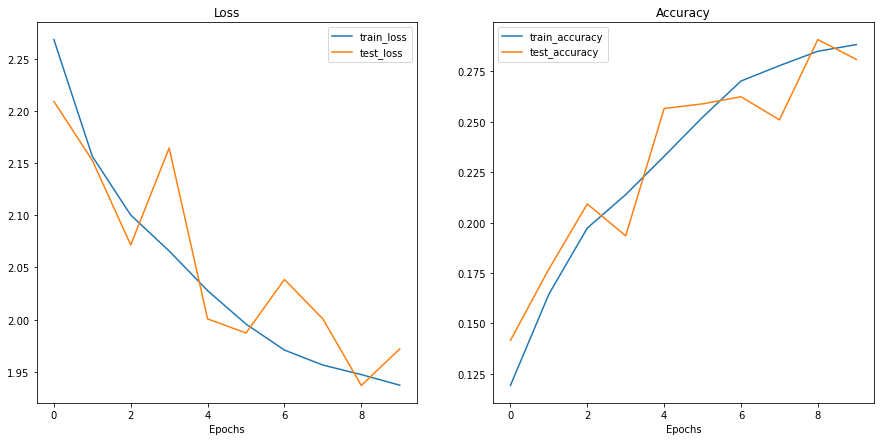

[INFO] traning model_tanh_12_layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3042 | train_acc: 0.0969 | test_loss: 2.3033 | test_acc: 0.0971
Epoch: 2 | train_loss: 2.2522 | train_acc: 0.1267 | test_loss: 2.1651 | test_acc: 0.1666
Epoch: 3 | train_loss: 2.1598 | train_acc: 0.1611 | test_loss: 2.1260 | test_acc: 0.1646
Epoch: 4 | train_loss: 2.1312 | train_acc: 0.1712 | test_loss: 2.2905 | test_acc: 0.1379
Epoch: 5 | train_loss: 2.0958 | train_acc: 0.1982 | test_loss: 2.1463 | test_acc: 0.1916
Epoch: 6 | train_loss: 2.0636 | train_acc: 0.2093 | test_loss: 2.0455 | test_acc: 0.2235
Epoch: 7 | train_loss: 2.0475 | train_acc: 0.2179 | test_loss: 2.0053 | test_acc: 0.2283
Epoch: 8 | train_loss: 2.0335 | train_acc: 0.2245 | test_loss: 2.0429 | test_acc: 0.2241
Epoch: 9 | train_loss: 2.0188 | train_acc: 0.2348 | test_loss: 1.9982 | test_acc: 0.2332
Epoch: 10 | train_loss: 2.0078 | train_acc: 0.2371 | test_loss: 2.0054 | test_acc: 0.2471
total training time: 226.303 sec.


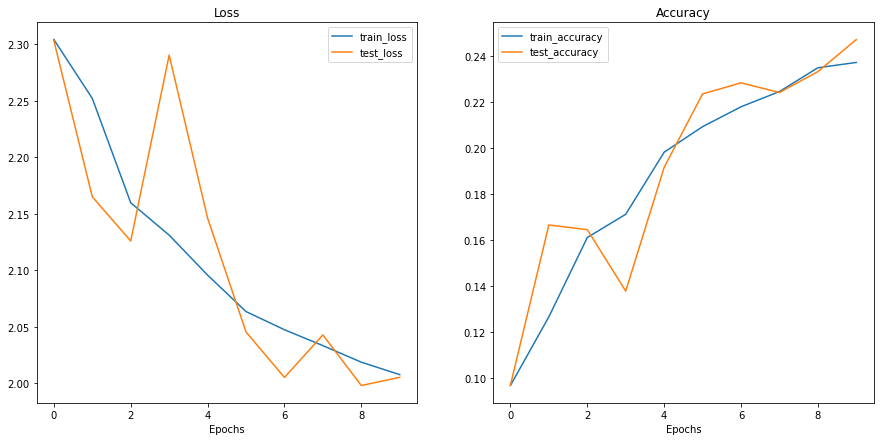

[INFO] traning model_tanh_14_layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3044 | train_acc: 0.0963 | test_loss: 2.3035 | test_acc: 0.0967
Epoch: 2 | train_loss: 2.3037 | train_acc: 0.0971 | test_loss: 2.3046 | test_acc: 0.0971
Epoch: 3 | train_loss: 2.3036 | train_acc: 0.0972 | test_loss: 2.3030 | test_acc: 0.0968
Epoch: 4 | train_loss: 2.3034 | train_acc: 0.0972 | test_loss: 2.3025 | test_acc: 0.0969
Epoch: 5 | train_loss: 2.2130 | train_acc: 0.1463 | test_loss: 2.1478 | test_acc: 0.1625
Epoch: 6 | train_loss: 2.1545 | train_acc: 0.1582 | test_loss: 2.1224 | test_acc: 0.1753
Epoch: 7 | train_loss: 2.1337 | train_acc: 0.1666 | test_loss: 2.1195 | test_acc: 0.1756
Epoch: 8 | train_loss: 2.1176 | train_acc: 0.1754 | test_loss: 2.0978 | test_acc: 0.1803
Epoch: 9 | train_loss: 2.1025 | train_acc: 0.1851 | test_loss: 2.0825 | test_acc: 0.1916
Epoch: 10 | train_loss: 2.0905 | train_acc: 0.1909 | test_loss: 2.0732 | test_acc: 0.2024
total training time: 232.271 sec.


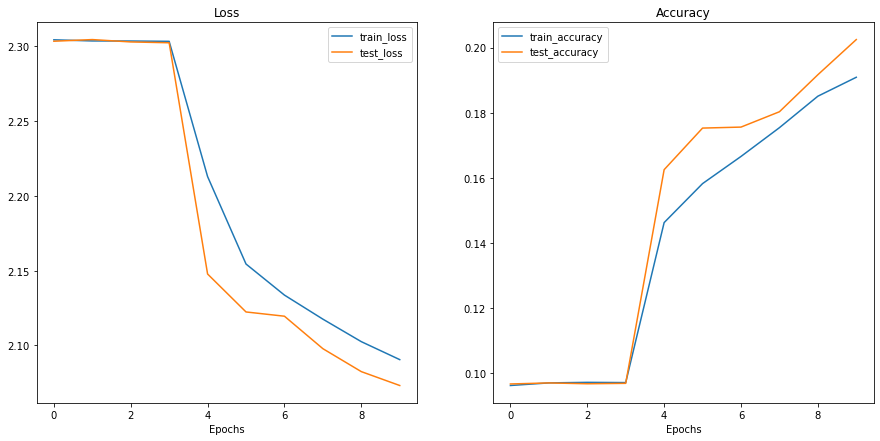

[INFO] traning model_tanh_16_layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3042 | train_acc: 0.0969 | test_loss: 2.3031 | test_acc: 0.0962
Epoch: 2 | train_loss: 2.3038 | train_acc: 0.0963 | test_loss: 2.3034 | test_acc: 0.0971
Epoch: 3 | train_loss: 2.3038 | train_acc: 0.0965 | test_loss: 2.3029 | test_acc: 0.0967
Epoch: 4 | train_loss: 2.3035 | train_acc: 0.0966 | test_loss: 2.3035 | test_acc: 0.0967
Epoch: 5 | train_loss: 2.3036 | train_acc: 0.0966 | test_loss: 2.3033 | test_acc: 0.0969
Epoch: 6 | train_loss: 2.3037 | train_acc: 0.0954 | test_loss: 2.3042 | test_acc: 0.0969
Epoch: 7 | train_loss: 2.3036 | train_acc: 0.0961 | test_loss: 2.3033 | test_acc: 0.0965
Epoch: 8 | train_loss: 2.3037 | train_acc: 0.0968 | test_loss: 2.3033 | test_acc: 0.0967
Epoch: 9 | train_loss: 2.3035 | train_acc: 0.0962 | test_loss: 2.3035 | test_acc: 0.0965
Epoch: 10 | train_loss: 2.3036 | train_acc: 0.0968 | test_loss: 2.3030 | test_acc: 0.0962
total training time: 239.509 sec.


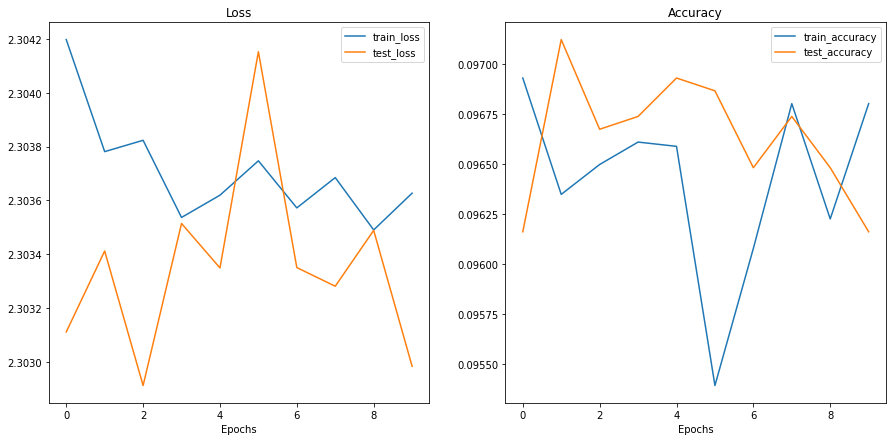

[INFO] traning model_tanh_18_layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3043 | train_acc: 0.0966 | test_loss: 2.3036 | test_acc: 0.0962
Epoch: 2 | train_loss: 2.3037 | train_acc: 0.0963 | test_loss: 2.3043 | test_acc: 0.0972
Epoch: 3 | train_loss: 2.3039 | train_acc: 0.0968 | test_loss: 2.3034 | test_acc: 0.0969
Epoch: 4 | train_loss: 2.3037 | train_acc: 0.0964 | test_loss: 2.3042 | test_acc: 0.0965
Epoch: 5 | train_loss: 2.3037 | train_acc: 0.0964 | test_loss: 2.3037 | test_acc: 0.0965
Epoch: 6 | train_loss: 2.3038 | train_acc: 0.0964 | test_loss: 2.3036 | test_acc: 0.0966
Epoch: 7 | train_loss: 2.3037 | train_acc: 0.0957 | test_loss: 2.3031 | test_acc: 0.0960
Epoch: 8 | train_loss: 2.3037 | train_acc: 0.0964 | test_loss: 2.3033 | test_acc: 0.0962
Epoch: 9 | train_loss: 2.3035 | train_acc: 0.0964 | test_loss: 2.3033 | test_acc: 0.0960
Epoch: 10 | train_loss: 2.3036 | train_acc: 0.0959 | test_loss: 2.3029 | test_acc: 0.0964
total training time: 246.773 sec.


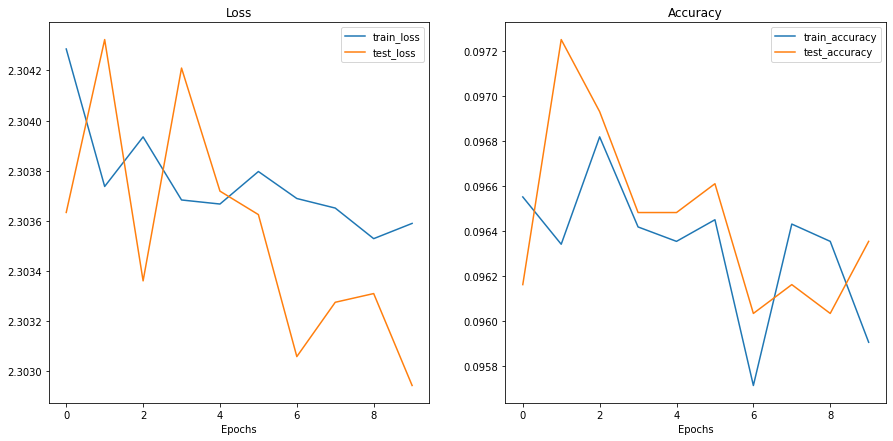

[INFO] traning model_tanh_20_layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3042 | train_acc: 0.0966 | test_loss: 2.3048 | test_acc: 0.0967
Epoch: 2 | train_loss: 2.3039 | train_acc: 0.0971 | test_loss: 2.3032 | test_acc: 0.0959
Epoch: 3 | train_loss: 2.3036 | train_acc: 0.0958 | test_loss: 2.3041 | test_acc: 0.0962
Epoch: 4 | train_loss: 2.3035 | train_acc: 0.0966 | test_loss: 2.3057 | test_acc: 0.0965
Epoch: 5 | train_loss: 2.3037 | train_acc: 0.0969 | test_loss: 2.3039 | test_acc: 0.0967
Epoch: 6 | train_loss: 2.3035 | train_acc: 0.0961 | test_loss: 2.3032 | test_acc: 0.0965
Epoch: 7 | train_loss: 2.3037 | train_acc: 0.0971 | test_loss: 2.3036 | test_acc: 0.0965
Epoch: 8 | train_loss: 2.3037 | train_acc: 0.0960 | test_loss: 2.3032 | test_acc: 0.0958
Epoch: 9 | train_loss: 2.3037 | train_acc: 0.0966 | test_loss: 2.3035 | test_acc: 0.0971
Epoch: 10 | train_loss: 2.3033 | train_acc: 0.0964 | test_loss: 2.3032 | test_acc: 0.0967
total training time: 252.762 sec.


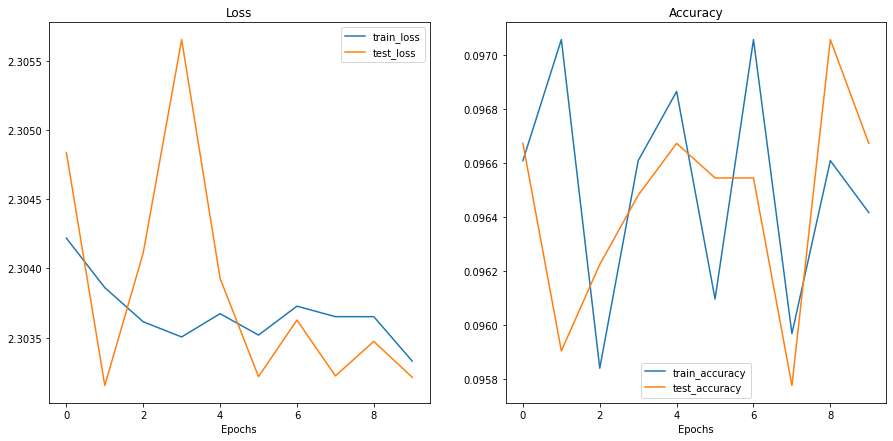

In [ ]:
for layer_counts in range(10,21,2):
  # making model object with sigmoid and layer count
  model_tanh_x_layers = CIFAR10Model0(
    in_channels = height*width,
    hidden_units = 16,
    out_channels = len(class_names),
    num_layers = layer_counts,
    activation_funtion = nn.Tanh()
    ).to(device)
  # print("\nMODEL INFO: \n")
  # print(model_tanh_x_layers)
  
  
  print(f"[INFO] traning model_tanh_{layer_counts}_layers")
  # training the model
  # init. epochs
  NUM_EPOCHS = 10

  # init. loss function, accuracy function and optimizer
  loss_fn = nn.CrossEntropyLoss()
  acc_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)
  optimizer = torch.optim.SGD(params=model_tanh_x_layers.parameters(), lr=0.1)

  # importing and init. the timer for checking model training time
  from timeit import default_timer as timer
  start_time = timer()

  # train model
  model_tanh_x_layers_results = train(model=model_tanh_x_layers, 
                          train_dataloader=train_dataloader,
                          test_dataloader=test_dataloader,
                          optimizer=optimizer,
                          loss_fn=loss_fn, 
                          acc_fn=acc_fn,
                          epochs=NUM_EPOCHS)


  # end timer
  end_time = timer()
  # printing time taken
  print(f"total training time: {end_time-start_time:.3f} sec.")
  plot_loss_curves(model_tanh_x_layers_results)
  # print("model stats:")
  # print(model_0_results)

### Solution for vanishing gradiant porblem using non-linear activation function (ReLU)

[INFO] traning model_relu_10_layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3039 | train_acc: 0.0963 | test_loss: 2.3042 | test_acc: 0.0964
Epoch: 2 | train_loss: 2.3035 | train_acc: 0.0968 | test_loss: 2.3037 | test_acc: 0.0973
Epoch: 3 | train_loss: 2.3032 | train_acc: 0.0974 | test_loss: 2.3036 | test_acc: 0.0959
Epoch: 4 | train_loss: 2.3022 | train_acc: 0.0995 | test_loss: 2.2937 | test_acc: 0.0965
Epoch: 5 | train_loss: 2.1901 | train_acc: 0.1501 | test_loss: 2.2173 | test_acc: 0.1410
Epoch: 6 | train_loss: 2.1224 | train_acc: 0.1738 | test_loss: 2.1066 | test_acc: 0.1820
Epoch: 7 | train_loss: 2.0964 | train_acc: 0.1841 | test_loss: 2.0761 | test_acc: 0.1913
Epoch: 8 | train_loss: 2.0821 | train_acc: 0.1891 | test_loss: 2.0644 | test_acc: 0.1894
Epoch: 9 | train_loss: 2.0714 | train_acc: 0.1916 | test_loss: 2.0584 | test_acc: 0.1947
Epoch: 10 | train_loss: 2.0664 | train_acc: 0.1932 | test_loss: 2.0682 | test_acc: 0.1900
total training time: 226.109 sec.


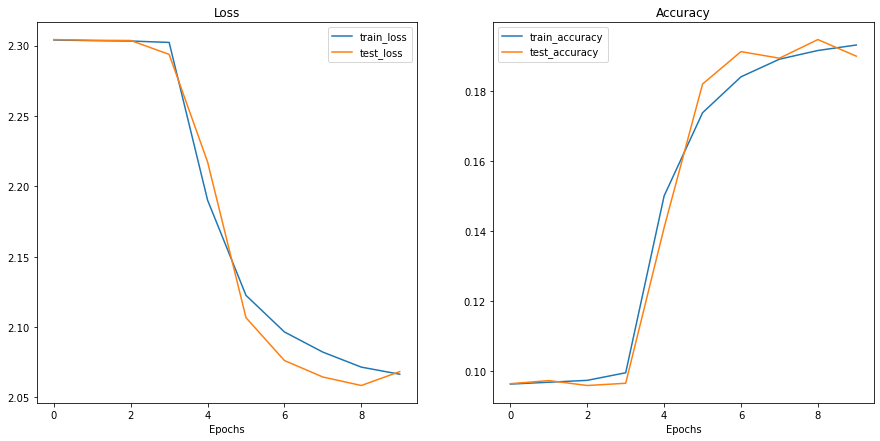

[INFO] traning model_relu_12_layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3038 | train_acc: 0.0967 | test_loss: 2.3035 | test_acc: 0.0971
Epoch: 2 | train_loss: 2.3037 | train_acc: 0.0962 | test_loss: 2.3031 | test_acc: 0.0967
Epoch: 3 | train_loss: 2.3036 | train_acc: 0.0959 | test_loss: 2.3030 | test_acc: 0.0956
Epoch: 4 | train_loss: 2.3035 | train_acc: 0.0967 | test_loss: 2.3035 | test_acc: 0.0965
Epoch: 5 | train_loss: 2.3035 | train_acc: 0.0964 | test_loss: 2.3036 | test_acc: 0.0968
Epoch: 6 | train_loss: 2.3032 | train_acc: 0.0961 | test_loss: 2.3038 | test_acc: 0.0964
Epoch: 7 | train_loss: 2.3035 | train_acc: 0.0958 | test_loss: 2.3032 | test_acc: 0.0964
Epoch: 8 | train_loss: 2.3034 | train_acc: 0.0968 | test_loss: 2.3031 | test_acc: 0.0968
Epoch: 9 | train_loss: 2.3034 | train_acc: 0.0963 | test_loss: 2.3030 | test_acc: 0.0964
Epoch: 10 | train_loss: 2.3033 | train_acc: 0.0980 | test_loss: 2.3036 | test_acc: 0.0969
total training time: 229.629 sec.


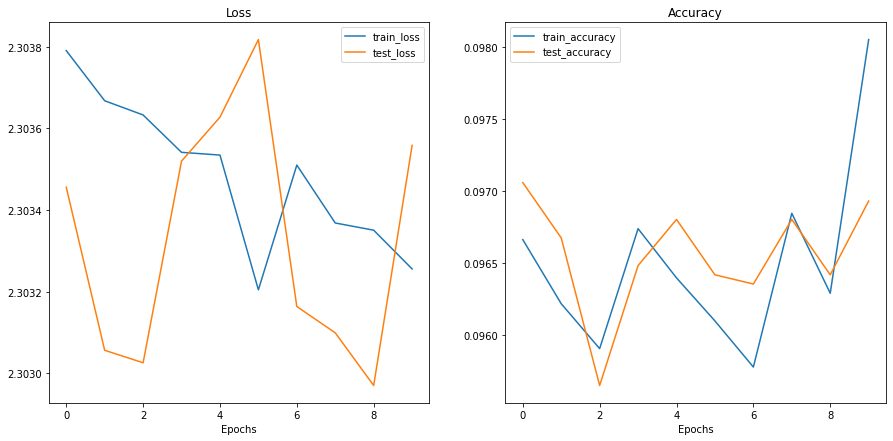

[INFO] traning model_relu_14_layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3041 | train_acc: 0.0961 | test_loss: 2.3031 | test_acc: 0.0966
Epoch: 2 | train_loss: 2.3035 | train_acc: 0.0971 | test_loss: 2.3028 | test_acc: 0.0967
Epoch: 3 | train_loss: 2.3035 | train_acc: 0.0964 | test_loss: 2.3028 | test_acc: 0.0966
Epoch: 4 | train_loss: 2.3034 | train_acc: 0.0967 | test_loss: 2.3032 | test_acc: 0.0965
Epoch: 5 | train_loss: 2.3034 | train_acc: 0.0964 | test_loss: 2.3040 | test_acc: 0.0967
Epoch: 6 | train_loss: 2.3034 | train_acc: 0.0967 | test_loss: 2.3034 | test_acc: 0.0964
Epoch: 7 | train_loss: 2.3034 | train_acc: 0.0962 | test_loss: 2.3037 | test_acc: 0.0972
Epoch: 8 | train_loss: 2.3033 | train_acc: 0.0967 | test_loss: 2.3031 | test_acc: 0.0960
Epoch: 9 | train_loss: 2.3032 | train_acc: 0.0962 | test_loss: 2.3035 | test_acc: 0.0964
Epoch: 10 | train_loss: 2.3034 | train_acc: 0.0963 | test_loss: 2.3030 | test_acc: 0.0965
total training time: 234.786 sec.


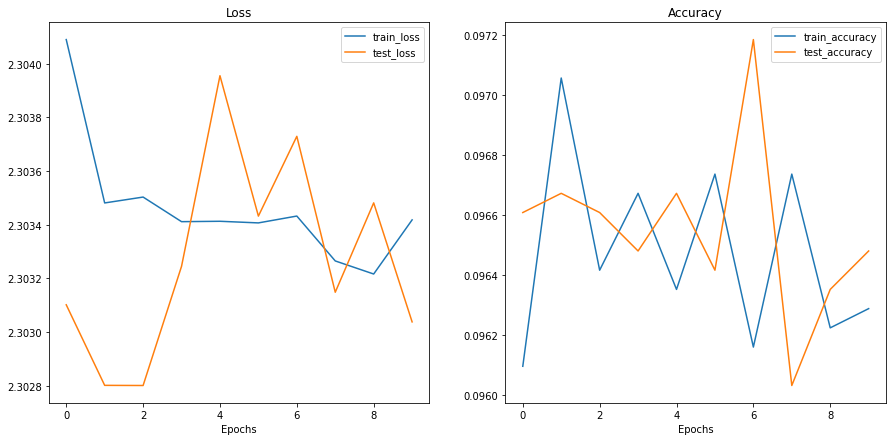

[INFO] traning model_relu_16_layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3040 | train_acc: 0.0960 | test_loss: 2.3029 | test_acc: 0.0957
Epoch: 2 | train_loss: 2.3036 | train_acc: 0.0970 | test_loss: 2.3029 | test_acc: 0.0964
Epoch: 3 | train_loss: 2.3035 | train_acc: 0.0980 | test_loss: 2.3038 | test_acc: 0.0965
Epoch: 4 | train_loss: 2.3035 | train_acc: 0.0971 | test_loss: 2.3038 | test_acc: 0.0962
Epoch: 5 | train_loss: 2.3035 | train_acc: 0.0965 | test_loss: 2.3032 | test_acc: 0.0970
Epoch: 6 | train_loss: 2.3035 | train_acc: 0.0963 | test_loss: 2.3034 | test_acc: 0.0966
Epoch: 7 | train_loss: 2.3035 | train_acc: 0.0965 | test_loss: 2.3029 | test_acc: 0.0960
Epoch: 8 | train_loss: 2.3033 | train_acc: 0.0962 | test_loss: 2.3031 | test_acc: 0.0965
Epoch: 9 | train_loss: 2.3033 | train_acc: 0.0965 | test_loss: 2.3033 | test_acc: 0.0969
Epoch: 10 | train_loss: 2.3032 | train_acc: 0.0966 | test_loss: 2.3035 | test_acc: 0.0971
total training time: 240.799 sec.


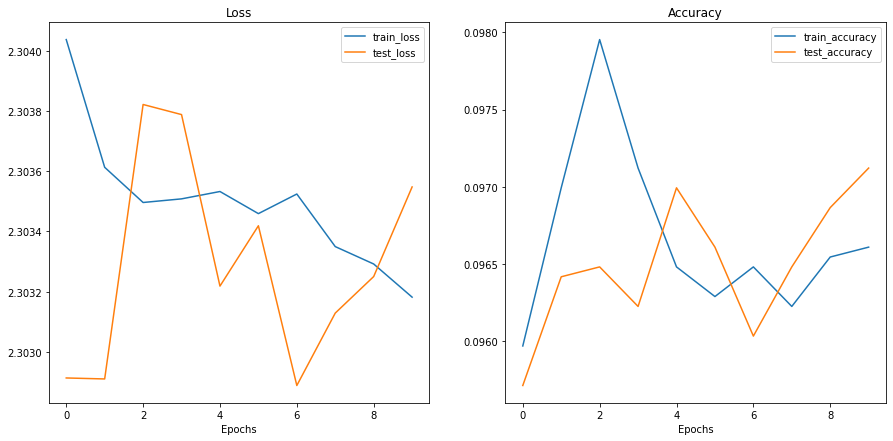

[INFO] traning model_relu_18_layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3039 | train_acc: 0.0964 | test_loss: 2.3039 | test_acc: 0.0972
Epoch: 2 | train_loss: 2.3037 | train_acc: 0.0964 | test_loss: 2.3034 | test_acc: 0.0965
Epoch: 3 | train_loss: 2.3036 | train_acc: 0.0960 | test_loss: 2.3035 | test_acc: 0.0970
Epoch: 4 | train_loss: 2.3035 | train_acc: 0.0965 | test_loss: 2.3028 | test_acc: 0.0972
Epoch: 5 | train_loss: 2.3034 | train_acc: 0.0969 | test_loss: 2.3033 | test_acc: 0.0965
Epoch: 6 | train_loss: 2.3033 | train_acc: 0.0969 | test_loss: 2.3033 | test_acc: 0.0964
Epoch: 7 | train_loss: 2.3034 | train_acc: 0.0978 | test_loss: 2.3033 | test_acc: 0.0972
Epoch: 8 | train_loss: 2.3032 | train_acc: 0.0969 | test_loss: 2.3035 | test_acc: 0.0960
Epoch: 9 | train_loss: 2.3034 | train_acc: 0.0967 | test_loss: 2.3029 | test_acc: 0.0965
Epoch: 10 | train_loss: 2.3033 | train_acc: 0.0964 | test_loss: 2.3033 | test_acc: 0.0971
total training time: 247.086 sec.


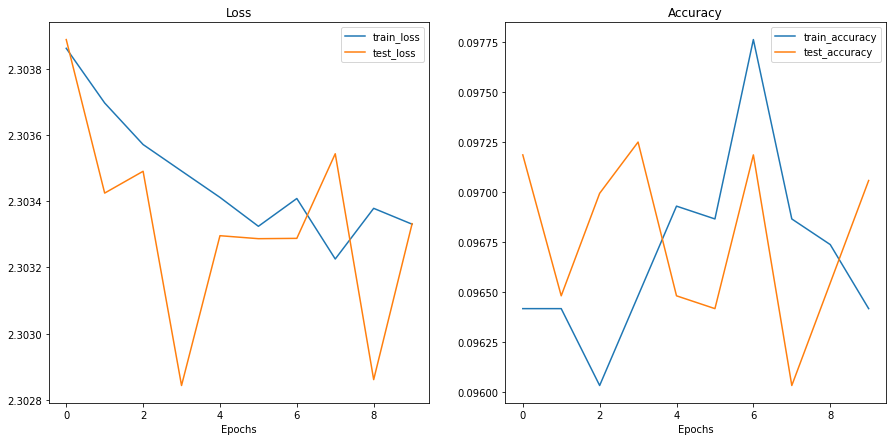

[INFO] traning model_relu_20_layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3039 | train_acc: 0.0962 | test_loss: 2.3033 | test_acc: 0.0974
Epoch: 2 | train_loss: 2.3035 | train_acc: 0.0958 | test_loss: 2.3037 | test_acc: 0.0968
Epoch: 3 | train_loss: 2.3036 | train_acc: 0.0960 | test_loss: 2.3032 | test_acc: 0.0962
Epoch: 4 | train_loss: 2.3036 | train_acc: 0.0968 | test_loss: 2.3036 | test_acc: 0.0969
Epoch: 5 | train_loss: 2.3034 | train_acc: 0.0965 | test_loss: 2.3031 | test_acc: 0.0959
Epoch: 6 | train_loss: 2.3034 | train_acc: 0.0969 | test_loss: 2.3035 | test_acc: 0.0964
Epoch: 7 | train_loss: 2.3033 | train_acc: 0.0963 | test_loss: 2.3030 | test_acc: 0.0961
Epoch: 8 | train_loss: 2.3035 | train_acc: 0.0958 | test_loss: 2.3029 | test_acc: 0.0971
Epoch: 9 | train_loss: 2.3035 | train_acc: 0.0967 | test_loss: 2.3032 | test_acc: 0.0959
Epoch: 10 | train_loss: 2.3034 | train_acc: 0.0965 | test_loss: 2.3031 | test_acc: 0.0972
total training time: 255.403 sec.


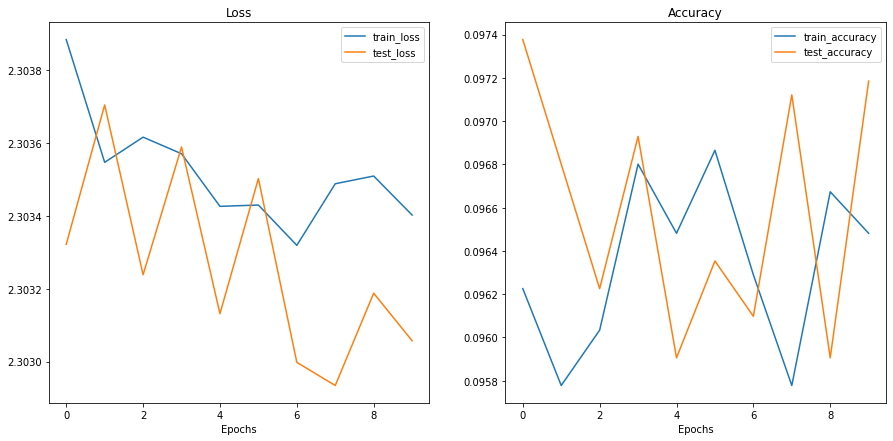

In [ ]:
for layer_counts in range(10,21,2):
  # making model object with relu and layer count
  model_relu_x_layers = CIFAR10Model0(
    in_channels = height*width,
    hidden_units = 16,
    out_channels = len(class_names),
    num_layers = layer_counts,
    activation_funtion = nn.ReLU()
    ).to(device)
  # print("\nMODEL INFO: \n")
  # print(model_relu_x_layers)
  
  
  print(f"[INFO] traning model_relu_{layer_counts}_layers")
  # training the model
  # init. epochs
  NUM_EPOCHS = 10

  # init. loss function, accuracy function and optimizer
  loss_fn = nn.CrossEntropyLoss()
  acc_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)
  optimizer = torch.optim.SGD(params=model_relu_x_layers.parameters(), lr=0.1)

  # importing and init. the timer for checking model training time
  from timeit import default_timer as timer
  start_time = timer()

  # train model
  model_relu_x_layers_results = train(model=model_relu_x_layers, 
                          train_dataloader=train_dataloader,
                          test_dataloader=test_dataloader,
                          optimizer=optimizer,
                          loss_fn=loss_fn, 
                          acc_fn=acc_fn,
                          epochs=NUM_EPOCHS)


  # end timer
  end_time = timer()
  # printing time taken
  print(f"total training time: {end_time-start_time:.3f} sec.")
  plot_loss_curves(model_relu_x_layers_results)
  # print("model stats:")
  # print(model_0_results)